## Gemini multimodality getting-sarted

Gemini is the most advanced and versatile model developed by Google to-date. It results from a large-scale collaborative effort by teams across Google, including Google DeepMind and Google Research. In this notebook, we will explore Gemini's capabilities for analyzing and working with multimodal data.



In [29]:
!pip install --upgrade google-cloud-aiplatform -q

In [30]:
import IPython
import time
import typing
import sys
from matplotlib.pylab import plt
from PIL.Image import Image as PILImageType
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from PIL import ImageOps as PILImageOps
import requests
from io import BytesIO
import json
import markdown
from pathlib import Path
from urllib.parse import urlparse
import vertexai
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

In [31]:
def restart_kernel() -> typing.NoReturn:
    """
    restart colab kernel
    """
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

def is_colab_env() -> bool:
    """
    return true if Colab is the execution env, otherwise false
    """
    return "google.colab" in sys.modules

def auth_with_gcp() -> typing.NoReturn:
    """
    Authenticate with GCP
    """
    if is_colab_env():
         # Authenticate user to Google Cloud
        from google.colab import auth
        auth.authenticate_user()

def is_valid_uri(uri: str) -> bool:
    """
    Check if a URI is valid.
    :param uri: URI
    :return: True if the URI is valid, False otherwise
    """
    try:
        result = urlparse(uri)
        # Check if the scheme and netloc are present
        return all([result.scheme, result.netloc])
    except:
        return False


def solve_image_url(url: str) -> str:
    """
    converts gcs uri to url for image display.
    """
    url_parts = urlparse(url)
    scheme = url_parts.scheme
    if scheme == "gs":
        return "https://storage.googleapis.com/" + url.replace("gs://", "").replace(
            " ", "%20"
        )
    elif scheme in ["http", "https"]:
        return url
    raise Exception("Invalid scheme")

def get_image_from_url(url: str) -> PILImageType:
    """
    Create an image from url and return it
    """
    http_uri =solve_image_url(url)
    response = requests.get(http_uri)
    image_bytes = BytesIO(response.content)
    image_obj = PILImage.open(image_bytes)
    return image_obj

def get_image_from_path(path: str) -> PILImageType:
    """
    Read image from file and return it
    """
    return PILImage.open(path)


def get_image_from_anywhere(uri_or_path: str) -> PILImageType:
    """
    read an image from an url or local file and return it
    """
    uri_or_path = str(uri_or_path)
    if is_valid_uri(uri_or_path):
        return get_image_from_url(uri_or_path)
    else:
        return get_image_from_path(uri_or_path)


def get_image_from_part(prompt_part: Part) -> PILImageType:
    """
    convert a. multimodal prompt part to and image
    """
    is_an_image = isinstance(prompt_part, Image)
    is_a_part = isinstance(prompt_part, Part)

    assert any([is_an_image, is_a_part]), "Invalid prompt part"
    if is_an_image:
        img = prompt_part._pil_image
    elif is_a_part:
        part_uri = prompt_part.file_data.file_uri
        img = get_image_from_url(part_uri)
    return img


def display_content_as_image(
        content: str | Image | Part,
        max_width: int = 600,
        max_height: int = 350) -> bool:
    """
    Display multimodal prompt part as image
    """
    if not isinstance(content, (Image, Part)):
        return False
    try:
        pil_image = get_image_from_part(content)
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PILImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)
    except:
        return False
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    """
    Display multimodal prompt part as video
    """
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

def markdown2json(markdown_str : str):
    """
    transform a markdown json str into a json object
    """
    start = "```json"
    end = "```"
    markdown_str=markdown_str.replace(start,"*")
    markdown_str=markdown_str.replace(end,"*")
    re=markdown_str.split("*")
    res=re[1]
    json_obj = json.loads(res)
    return json_obj


In [4]:
#restart_kernel()

In [32]:
auth_with_gcp()

In [33]:
!gcloud projects list | grep "build-with-ai"

build-with-ai-project       Build-With-AI-Project       430300616222


# Getting-Started with Gemini API

In [34]:
# Define project information
PROJECT_ID = "build-with-ai-project"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [35]:
model = GenerativeModel("gemini-1.0-pro")
responses = model.generate_content("Why is the sky blue?", stream=True)
for response in responses:
    print(response.text, end="")

The sky appears blue because of a phenomenon called Rayleigh scattering. This is the scattering of electromagnetic radiation by particles of a much smaller wavelength.

When sunlight enters the Earth's atmosphere, it is scattered in all directions by molecules of nitrogen and oxygen. However, the shorter wavelength blue light is scattered more than the longer wavelength red light, because the shorter wavelength light has a higher frequency and therefore interacts more strongly with the molecules. This is because the scattering cross-section is inversely proportional to the fourth power of the wavelength, so blue light is scattered about four times as much as red light.

The scattered blue light is what we see when we look up at the sky. The amount of scattering depends on the wavelength of the light and the size and density of the scattering particles. In the Earth's atmosphere, the molecules of nitrogen and oxygen are much smaller than the wavelength of visible light, so the scatterin

In [36]:
prompt = """Create a numbered list of 10 items. Each item in the list should be a trend in the tech industry.
Each trend should be less than 5 words."""  # try your own prompt
responses = model.generate_content(prompt, stream=True)
for response in responses:
    print(response.text, end="")

1. Artificial intelligence
2. Cloud computing
3. Blockchain
4. Big data
5. Cybersecurity
6. Internet of things
7. Virtual reality
8. Augmented reality
9. Robotics
10. Quantum computing

In [37]:
chat = model.start_chat()
prompt = """My name is Ned. You are my personal assistant. My favorite movies are Lord of the Rings and Hobbit.
Suggest another movie I might like.
"""
responses = chat.send_message(prompt, stream=True)
for response in responses:
    print(response.text, end="")

**Fantasy Epics:**

* **The Princess Bride** (1987): A timeless classic with a charming story, memorable characters, and epic sword-fighting.
* **Harry Potter and the Sorcerer's Stone** (2001): The first installment in the beloved wizarding world series, featuring magic, adventure, and lovable characters.
* **The Chronicles of Narnia: The Lion, the Witch and the Wardrobe** (2005): A magical adventure set in a fantastical land with talking animals, a wise lion, and a clash between good and evil.

**Epic Adventures:**

* **Indiana Jones and the Raiders of the Lost Ark** (1981): A thrilling adventure with archaeology, ancient curses, and a charismatic treasure hunter.
* **Pirates of the Caribbean: The Curse of the Black Pearl** (2003): A swashbuckling pirate adventure with supernatural elements, stunning visuals, and memorable characters.
* **Star Wars: Episode IV - A New Hope** (1977): The first installment in the legendary Star Wars saga, featuring space battles, iconic characters, and 

In [38]:
prompt = "Are my favorite movies based on a book series?"
responses = chat.send_message(prompt, stream=True)
for response in responses:
    print(response.text, end="")

Yes, both **The Lord of the Rings** and **The Hobbit** are based on book series by J.R.R. Tolkien.

* **The Lord of the Rings** is a trilogy of novels published between 1954 and 1955. It tells the epic tale of the quest to destroy the One Ring, an evil artifact created by the Dark Lord Sauron.
* **The Hobbit** is a prequel to The Lord of the Rings, published in 1937. It follows the adventures of Bilbo Baggins, a hobbit who joins a group of dwarves on a quest to reclaim their lost kingdom from the dragon Smaug.

Both book series have been highly acclaimed for their rich world-building, complex characters, and timeless themes. They have also been adapted into several successful film trilogies, directed by Peter Jackson.

In [39]:
chat.history


[role: "user"
 parts {
   text: "My name is Ned. You are my personal assistant. My favorite movies are Lord of the Rings and Hobbit.\nSuggest another movie I might like.\n"
 },
 role: "model"
 parts {
   text: "**Fantasy Epics:**\n\n* **The Princess Bride** (1987): A timeless classic with a charming story, memorable characters, and epic sword-fighting.\n* **Harry Potter and the Sorcerer\'s Stone** (2001): The first installment in the beloved wizarding world series, featuring magic, adventure, and lovable characters.\n* **The Chronicles of Narnia: The Lion, the Witch and the Wardrobe** (2005): A magical adventure set in a fantastical land with talking animals, a wise lion, and a clash between good and evil.\n\n**Epic Adventures:**\n\n* **Indiana Jones and the Raiders of the Lost Ark** (1981): A thrilling adventure with archaeology, ancient curses, and a charismatic treasure hunter.\n* **Pirates of the Caribbean: The Curse of the Black Pearl** (2003): A swashbuckling pirate adventure wit

# Exploring Multimodal Capabilities


# Image understanding

Copying gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg...
/ [1 files][ 17.4 KiB/ 17.4 KiB]                                                
Operation completed over 1 objects/17.4 KiB.                                     


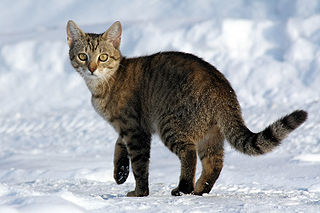

Describe this image?
 This is a photo of a cat walking in the snow. The cat is brown and white, and it has a long tail. The cat is walking towards the camera, and it is looking at the camera. The snow is white and it is covering the ground.

In [40]:
# initialize the model
multimodal_model = GenerativeModel("gemini-1.0-pro-vision")

# Download an image from Google Cloud Storage
! gsutil cp "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg" ./image.jpg

# Prepare model request
image = Image.load_from_file("image.jpg")
prompt = "Describe this image?"

multimodal_prompt = [image, prompt]
print_multimodal_prompt(multimodal_prompt)

gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")

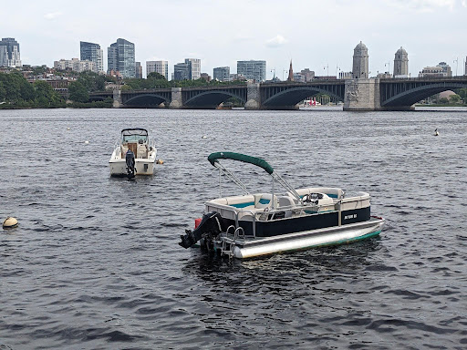

Describe the scene?
 Two pontoon boats are anchored in the Charles River in Boston, Massachusetts. In the background are two bridges and the Boston skyline.

In [41]:
# Load image from Cloud Storage URI
gcs_uri = "gs://cloud-samples-data/generative-ai/image/boats.jpeg"

# Prepare contents
image = Part.from_uri(gcs_uri, mime_type="image/jpeg")
prompt = "Describe the scene?"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")


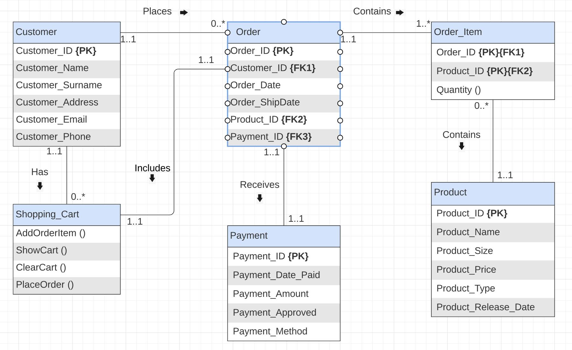

Describe the ERD diagram
Generates the sql code to create the schema in the image


In [42]:
# Download image from URL and save it locally
image_url = "https://i.stack.imgur.com/676e8.png"
image_pil = get_image_from_url(image_url)
# Entity Relationship Diagram (ERD)?
image_path = "diagram.jpeg"
image_pil = image_pil.convert("RGB")
image_pil.save(image_path)

# Prepare contents
image = Image.load_from_file(image_path)
description_prompt = "Describe the ERD diagram"
sql_prompt = "Generates the sql code to create the schema in the image"
multimodal_prompt = [image, description_prompt, sql_prompt]
print_multimodal_prompt(multimodal_prompt)


In [43]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
# max_output_tokens -> supported range [1, 2049)
try:
    for result in gemini_responses:
        print(result.text, end="") # it should throw an error
except Exception as e:
    print(e)

 The ERD diagram describes a database with the following tables:

```
Customer
Order
Shopping_Cart
Payment
Product
Order_Item
```

The Customer table has the following columns:

```
Customer_ID (PK)
Customer_Name
Customer_Surname
Customer_Address
Customer_Email
Customer_Phone
```

The Order table has the following columns:

```
Order_ID (PK)
Customer_ID (FK1)
Order_Date
Order_ShipDate
Product_ID (FK2)
Payment_ID (FK3)
```

The Shopping_Cart table has the following columns:

```
Customer_ID (PK)
Product_ID
Quantity
```

The Payment table has the following columns:

```
Payment_ID (PK)
Payment_Date_Paid
Payment_Amount
Payment_Approved
Payment_Method
```

The Product table has the following columns:

```
Product_ID (PK)
Product_Name
Product_Size
Product_Price
Product_Type
Product_Release_Date
```

The Order_Item table has the following columns:

```
Order_ID (PK) (FK1)
Product_ID (PK) (FK2)
Quantity
```

The SQL code to create the schema in the image is as follows:

```sql
CREATE TABLE Cu

**Split the prompt could help**

In [44]:
multimodal_prompt = [image, description_prompt]
gemini_response = multimodal_model.generate_content(multimodal_prompt)
print(gemini_response.text)

 The ERD diagram consists of the following tables:

- Customer: This table stores information about customers, such as their ID, name, surname, address, email, and phone number.
- Order: This table stores information about orders, such as the order ID, customer ID, order date, order ship date, product ID, and payment ID.
- Payment: This table stores information about payments, such as the payment ID, payment date, payment amount, payment approved, and payment method.
- Product: This table stores information about products, such as the product ID, product name, product size, product price, product type, and product release date.
- Order_Item: This table stores information about order items, such as the order ID, product ID, and quantity.
- Shopping_Cart: This table stores information about shopping carts, such as the customer ID and the products in the cart.

The ERD diagram also shows the relationships between the tables. For example, the Customer table is related to the Order table th

In [45]:
multimodal_prompt = [image, sql_prompt]
gemini_response = multimodal_model.generate_content(multimodal_prompt)
print(gemini_response.text)

 ```sql

CREATE TABLE Customer (
  Customer_ID INT NOT NULL AUTO_INCREMENT,
  Customer_Name VARCHAR(255) NOT NULL,
  Customer_Surname VARCHAR(255) NOT NULL,
  Customer_Address VARCHAR(255) NOT NULL,
  Customer_Email VARCHAR(255) NOT NULL,
  Customer_Phone VARCHAR(255) NOT NULL,
  PRIMARY KEY (Customer_ID)
);

CREATE TABLE Shopping_Cart (
  Customer_ID INT NOT NULL,
  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID)
);

CREATE TABLE Order (
  Order_ID INT NOT NULL AUTO_INCREMENT,
  Customer_ID INT NOT NULL,
  Order_Date DATE NOT NULL,
  Order_ShipDate DATE NOT NULL,
  Product_ID INT NOT NULL,
  Payment_ID INT NOT NULL,
  PRIMARY KEY (Order_ID),
  FOREIGN KEY (Customer_ID) REFERENCES Customer(Customer_ID),
  FOREIGN KEY (Product_ID) REFERENCES Product(Product_ID),
  FOREIGN KEY (Payment_ID) REFERENCES Payment(Payment_ID)
);

CREATE TABLE Payment (
  Payment_ID INT NOT NULL AUTO_INCREMENT,
  Payment_Date_Paid DATE NOT NULL,
  Payment_Amount INT NOT NULL,
  Payment_Approved BOOLE

## Configure generation

In [ ]:
from vertexai import generative_models

def generate_text(project_id: str, location: str, multimodal_prompt: typing.Tuple[Part, str]) -> str:
    # Initialize Vertex AI
    vertexai.init(project=project_id, location=location)

    # Load the model
    model = generative_models.GenerativeModel("gemini-1.0-pro-vision")

    """"
    # Generation config
    Temperature regulates randomness in token selection: low values ensure determinism for precise prompts, while high values foster creativity.
    At 0, selection is entirely deterministic, favoring the highest probability token consistently.
    max_output_tokens -> supported range [1, 2049)

    Top-K and Top-P mechanisms alter token selection: Top-K selects from the most probable tokens, while Top-P selects until the cumulative probability reaches a threshold.
    Temperature further refines selection, with lower values for less randomness and higher values for more diversity.
    Default values are 32 for Top-K and 1.0 for Top-P.
    """
    config = {"max_output_tokens": 2048, "temperature": 0.4, "top_p": 1, "top_k": 32}

    """
    # Safety config
    The Vertex AI Gemini API blocks unsafe content based on a list of safety attributes and their configured blocking thresholds
    """
    safety_config = {
        #generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_LOW_AND_ABOVE,
    }

    # Generate content
    promp_part, promp_text = multimodal_prompt
    print(promp_part, promp_text)

    responses = model.generate_content(
        [promp_part, promp_text],
        generation_config=config,
        #safety_settings=safety_config,
        stream=True
    )

    text_responses = []
    for response in responses:
        print(response.text)
        text_responses.append(response.text)
    return "".join(text_responses)

generate_text(PROJECT_ID, LOCATION, multimodal_prompt)

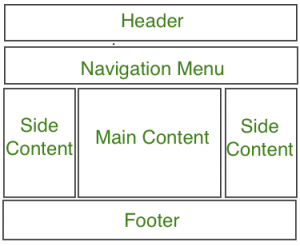

Create the HTMl code from this website mockup, each section should have a different color


In [46]:
# download and copy image locally
ui_image_url = "https://media.geeksforgeeks.org/wp-content/uploads/3-column-300x246.png"
ui_image_path = Path(ui_image_url).name
ui_image = get_image_from_anywhere(ui_image_url)
ui_image = ui_image.convert("RGB")
ui_image.save(ui_image_path)


# Prepare multimodal prompt
image = Image.load_from_file(ui_image_path)
prompt = "Create the HTMl code from this website mockup, each section should have a different color"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [47]:

from IPython.core.display import display, HTML

config = {"temperature": 0.0}
gemini_responses = multimodal_model.generate_content(
        multimodal_prompt,
        stream=True,
        generation_config=config
    )
streaming_chunks = []
for chunk in gemini_responses:
    chunk_text = chunk.text
    streaming_chunks.append(chunk_text)
    print(chunk_text, end="")

html_code = "".join(streaming_chunks)
display(HTML(html_code))

 ```html
<!DOCTYPE html>
<html>
<head>
  <title>Website Mockup</title>
  <style>
    header {
      background-color: #00FF00;
      padding: 20px;
      text-align: center;
    }

    nav {
      background-color: #FF00FF;
      padding: 20px;
      text-align: center;
    }

    main {
      background-color: #FFFFFF;
      padding: 20px;
    }

    aside {
      background-color: #FF0000;
      padding: 20px;
      text-align: center;
    }

    footer {
      background-color: #0000FF;
      padding: 20px;
      text-align: center;
    }
  </style>
</head>
<body>
  <header>
    <h1>Header</h1>
  </header>
  <nav>
    <a href="#">Navigation Menu</a>
  </nav>
  <main>
    <h1>Main Content</h1>
  </main>
  <aside>
    <h1>Side Content</h1>
  </aside>
  <footer>
    <h1>Footer</h1>
  </footer>
</body>
</html>
```

# Downstream tasks

# Image Classification

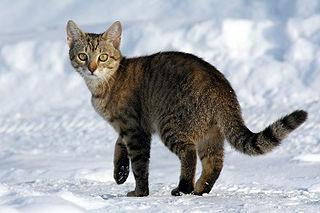

Classify the image, return the label in JSON format, with a label field


In [48]:
cat_image_uri = "gs://cloud-samples-data/generative-ai/image/320px-Felis_catus-cat_on_snow.jpg"
cat_image = get_image_from_anywhere(cat_image_uri)
cat_image = cat_image.convert("RGB")

# export image
cat_image_file = "cat.jpg"
cat_image.save(cat_image_file)

# Prepare contents
image = Image.load_from_file(cat_image_file)
prompt = "Classify the image, return the label in JSON format, with a label field"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [49]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
for result in gemini_responses:
    print(result.text, end="")

 ```json
{
  "label": "cat"
}
```

## Object Detection


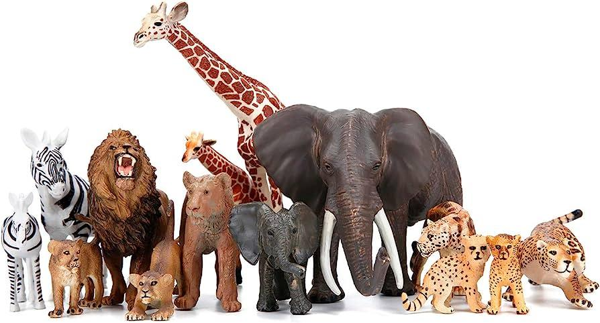

Detect the objects in the image, return the label and the bounding boxes in JSON format


In [50]:
# download image
zoo_image_url = "https://m.media-amazon.com/images/I/71LMIioO5tL._AC_UF894,1000_QL80_.jpg"
zoo_image = get_image_from_anywhere(zoo_image_url)
zoo_image = zoo_image.convert("RGB")

# export image
zoo_image_file = "zoo-animals.jpg"
zoo_image.save(zoo_image_file)

# Prepare contents
image = Image.load_from_file(zoo_image_file)
prompt = "Detect the objects in the image, return the label and the bounding boxes in JSON format"
multimodal_prompt = [image, prompt]

print_multimodal_prompt(multimodal_prompt)

In [51]:
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
streaming_chunks = []
for result in gemini_responses:
    chunk_text = result.text
    streaming_chunks.append(chunk_text)
    print(chunk_text, end="")

 ```json
{
  "objects": [
    {
      "label": "elephant",
      "bounding_box": {
        "x_min": 444,
        "y_min": 264,
        "x_max": 634,
        "y_max": 433
      }
    },
    {
      "label": "giraffe",
      "bounding_box": {
        "x_min": 26,
        "y_min": 134,
        "x_max": 134,
        "y_max": 434
      }
    },
    {
      "label": "lion",
      "bounding_box": {
        "x_min": 154,
        "y_min": 254,
        "x_max": 225,
        "y_max": 352
      }
    },
    {
      "label": "zebra",
      "bounding_box": {
        "x_min": 0,
        "y_min": 260,
        "x_max": 93,
        "y_max": 355
      }
    },
    {
      "label": "lion",
      "bounding_box": {
        "x_min": 100,
        "y_min": 265,
        "x_max": 149,
        "y_max": 324
      }
    },
    {
      "label": "cheetah",
      "bounding_box": {
        "x_min": 650,
        "y_min": 323,
        "x_max": 721,
        "y_max": 383
      }
    },
    {
      "label": "cheetah",
     

In [52]:
import json
import markdown
markdown_str = "".join(streaming_chunks)
bounding_boxes = markdown2json(markdown_str)
print(json.dumps(bounding_boxes, indent=2))

{
  "objects": [
    {
      "label": "elephant",
      "bounding_box": {
        "x_min": 444,
        "y_min": 264,
        "x_max": 634,
        "y_max": 433
      }
    },
    {
      "label": "giraffe",
      "bounding_box": {
        "x_min": 26,
        "y_min": 134,
        "x_max": 134,
        "y_max": 434
      }
    },
    {
      "label": "lion",
      "bounding_box": {
        "x_min": 154,
        "y_min": 254,
        "x_max": 225,
        "y_max": 352
      }
    },
    {
      "label": "zebra",
      "bounding_box": {
        "x_min": 0,
        "y_min": 260,
        "x_max": 93,
        "y_max": 355
      }
    },
    {
      "label": "lion",
      "bounding_box": {
        "x_min": 100,
        "y_min": 265,
        "x_max": 149,
        "y_max": 324
      }
    },
    {
      "label": "cheetah",
      "bounding_box": {
        "x_min": 650,
        "y_min": 323,
        "x_max": 721,
        "y_max": 383
      }
    },
    {
      "label": "cheetah",
      "boundin

### Video understanding

https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/intro_multimodal_use_cases.ipynb

**Question answering**

In [58]:
prompt_part = """
What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
Write a short poem with the tags on the image
"""
video_part = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4",
    mime_type="video/mp4",
)
multimodal_prompt = [
    prompt_part,
    video_part
]

responses = multimodal_model.generate_content(multimodal_prompt, stream=True)
print("-------Prompt--------")
print_multimodal_prompt(multimodal_prompt)



-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
Write a short poem with the tags on the image



In [59]:
for result in responses:
    print(result.text)

 This is a photo of the Mediterranean Sea in Turkey. 

You can visit this place by going to Turkey. 

The top 5 places in the world that look like this are:

1. Amalfi Coast, Italy
2. Cinque Terre, Italy
3. Santorini, Greece
4. Positano, Italy
5. Dubrovnik, Croatia

Here is a short poem about the Mediterranean Sea:

The Mediterranean Sea
Is a beautiful place to be
With its crystal-clear waters
And its sandy beaches

The sun shines brightly
And the waves crash gently
It's a perfect place to relax
And forget about your troubles

So if you're looking for a place to vacation
Where you can relax and enjoy the scenery
The Mediterranean Sea is the perfect place for you


**Tags extraction**

In [60]:
prompt = """
Answer the following questions using the video only:
- What is in the video?
- Provide 10 best tags for this video

Wrap the responses in a JSON object
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/photography.mp4",
    mime_type="video/mp4",
)
multimodal_prompt = [prompt, video]
gemini_responses = multimodal_model.generate_content(multimodal_prompt, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(multimodal_prompt)

print("\n-------Response--------")
for response in gemini_responses:
    print(response.text, end="")

-------Prompt--------

Answer the following questions using the video only:
- What is in the video?
- Provide 10 best tags for this video

Wrap the responses in a JSON object




-------Response--------
 ```json
{
  "tags": [
    "photographer",
    "camera",
    "man",
    "hat",
    "shorts",
    "statue",
    "art",
    "table",
    "wood",
    "concrete"
  ],
  "description": "A man wearing a hat and shorts is taking a picture of a statue in an art gallery."
}
```

**Image comparison**

-------Prompt--------

Consider the following two images:
Image 1:



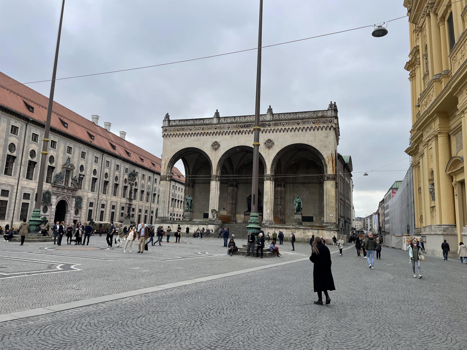


Image 2:



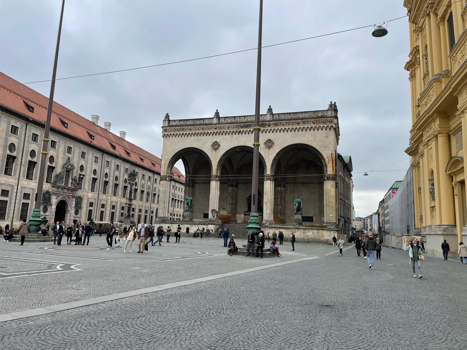


1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?


-------Response--------
 1. Image 1 shows a square with a large building in the background. There are people walking around the square.
2. Both images show the same square with the same buildings in the background.
3. The difference between the two images is that there are more people in Image 1.

In [61]:
image_landmark1_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark1.jpg"
image_landmark2_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/landmark2.jpg"
image_landmark1 = get_image_from_anywhere(image_landmark1_url)
image_landmark2 = get_image_from_anywhere(image_landmark2_url)

image_landmark1.save("image1.jpg")
image_landmark2.save("image2.jpg")


image_part_1 = Image.load_from_file("image1.jpg")
image_part_2 =  Image.load_from_file("image2.jpg")

prompt1 = """
Consider the following two images:
Image 1:
"""
prompt2 = """
Image 2:
"""
prompt3 = """
1. What is shown in Image 1?
2. What is similar between the two images?
3. What is difference between Image 1 and Image 2 in terms of the contents or people shown?
"""

contents = [prompt1, image_part_1, prompt2, image_part_2, prompt3]

generation_config = GenerationConfig(
    temperature=0.0,
    top_p=0.8,
    top_k=40,
    candidate_count=1, # # Generate only one output
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Sequence of images understanding

-------Prompt--------
Consider the following chairs:
chair 1:


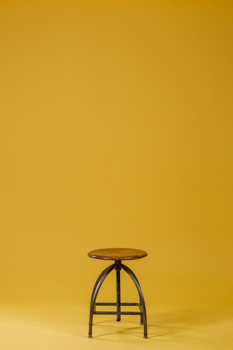

chair 2:


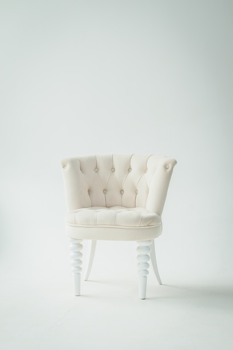

chair 3:


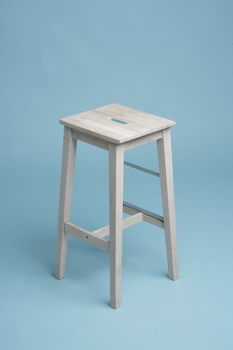

chair 4:


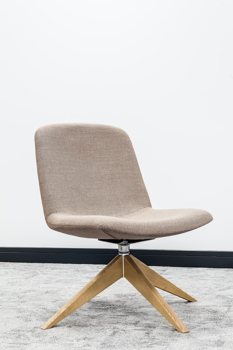

Which one is white color?

-------Response--------
 The second chair is white color.

In [62]:
import http.client
import io
import typing
import urllib.request

# Download and display sample images
furniture_image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        if response.headers["Content-Type"] not in ("image/png", "image/jpeg"):
            raise Exception("Image can only be in PNG or JPEG format")
        image_bytes = response.read()
    return image_bytes


def image_part_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


# Load furniture images as Image Objects
furniture_images = [image_part_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# That way you are providing the model with a way to reference each image as you pose a question.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Consider the following chairs:",
    "chair 1:",
    furniture_images[0],
    "chair 2:",
    furniture_images[1],
    "chair 3:",
    furniture_images[2],
    "chair 4:",
    furniture_images[3],
    "Which one is white color?",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Putting everything together into a multimodal RAG system


https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/intro_multimodal_rag.ipynb